# Simulated Bias Calculations

In [260]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp


# Hypothesis

## Hypothesis Bias Against 

In [261]:
def simulation_hypothesis_bias_against_normal_1p(n_sample, hypothesis, n_datasets = 1000, n_marginal = 1000, sigma = 1, prior_mu = 0, prior_σ = 1, cumulative=False):
    """
    Computes the cumulative sum of the bias against a normal hypothesis after a burn-in period, based on simulated 
    data from a normal distribution. The function evaluates the relative bias against a hypothesis by comparing 
    the hypothesis log-likelihood with the marginal log-likelihood using a set of sampled data points.

    Parameters:
    ----------
    n_sample : int
        The number of samples to draw for each dataset.
    hypothesis : float
        The mean of the normal distribution representing the hypothesis being tested.
    n_datasets : int, optional (default=1000)
        The number of datasets to generate for bias evaluation.
    n_marginal : int, optional (default=1000)
        The number of samples used to approximate the marginal likelihood.
    sigma : float, optional (default=1)
        The standard deviation of the normal distribution (assumed constant for all samples).
    prior_mu : float, optional (default=0)
        The mean of the prior distribution over the parameter.
    prior_σ : float, optional (default=1)
        The standard deviation of the prior distribution over the parameter.
    cumulative : bool, optional (default=False)
        If True, returns the cumulative sum of bias against the hypothesis after burn-in; otherwise, returns 
        the final value.

    Returns:
    -------
    np.ndarray or float
        A 1D array containing the cumulative sum of the bias against the hypothesis after burn-in (if `cumulative=True`), 
        or a single float representing the proportion of times bias against the hypothesis is observed (if `cumulative=False`).
    
    Internal Function:
    ------------------
    normal_logp_np(x, mu, sigma):
        Computes the log-likelihood of the normal distribution for input `x` given mean `mu` and standard deviation 
        `sigma`. This is used to calculate both the hypothesis log-likelihood and marginal log-likelihood.

    Algorithm Overview:
    -------------------
    1. Generate random samples `x` of size `(n_sample, n_datasets)` from the normal distribution defined by the hypothesis 
       mean and standard deviation `sigma`.
    2. Generate `n_marginal` random mean values `μ` from the prior distribution.
    3. Compute the log-likelihood of the data under the hypothesis (with fixed mean = `hypothesis`).
    4. Compute the marginal log-likelihood using logsumexp to account for the random means `μ` sampled from the prior.
    5. Compare the log-likelihood for the hypothesis with the marginal log-likelihood to determine if there is bias 
       against the hypothesis (when the log-likelihood is less than or equal to the marginal log-likelihood).

    Notes:
    ------
    - The function assumes that the hypothesis being tested is represented by a normal distribution with a known 
      standard deviation `sigma`.
    - A "bias against" the hypothesis is detected when the log-likelihood under the hypothesis is less than or equal 
      to the marginal log-likelihood.
    - The first 300 iterations are discarded to account for burn-in effects, focusing only on the remaining iterations 
      to calculate the cumulative bias.

    Example Usage:
    --------------
    # Example usage to compute bias against a normal hypothesis
    n_sample = 1000
    hypothesis = 0
    sigma = 1.0

    result = simulation_hypothesis_bias_against_normal_1p(n_sample, hypothesis, n_datasets=1000, sigma=sigma)
    """
    
    def normal_logp_np(x, mu, sigma):
        return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

    # Sample from the normal distribution for the hypothesis and for the μ values
    likeli_dist = stats.norm(loc=hypothesis, scale=sigma)
    prior_dist = stats.norm(loc=prior_mu, scale=prior_σ)
    x = likeli_dist.rvs(size=(n_sample, n_datasets))
    μ = prior_dist.rvs(size=(n_marginal))

    # Compute the log-likelihood for the hypothesis
    log_likelihood = normal_logp_np(x, hypothesis, sigma).sum(axis=0)
    
    # Compute the marginal log-likelihood using logsumexp for numerical stability
    log_marginal_likelihood = logsumexp(np.sum(normal_logp_np(x[:, :, np.newaxis], μ, sigma), axis=0), axis=1) - np.log(n_marginal)
    
    # Calculate the bias against
    bias_against = (log_likelihood - log_marginal_likelihood) <= 0
    bias_against_cumsum = bias_against.cumsum() / np.arange(1, len(bias_against) + 1)

    if cumulative: 
        return bias_against_cumsum[300:]
    else:
        return bias_against_cumsum[-1]


### Example

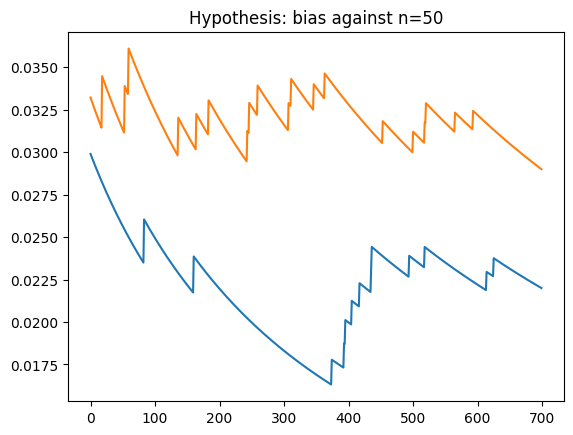

In [298]:
n = 5; n_datasets = 1000; hypothesis = 1; σ = 1

loops = 2
bias_against = [simulation_hypothesis_bias_against_normal_1p(n_sample=n, hypothesis=hypothesis, n_datasets=n_datasets, sigma = σ, cumulative=True) for i in range(loops)]

for i in range(loops):
    plt.plot(bias_against[i])
    plt.title(f"Hypothesis: bias against n=50")
plt.show()

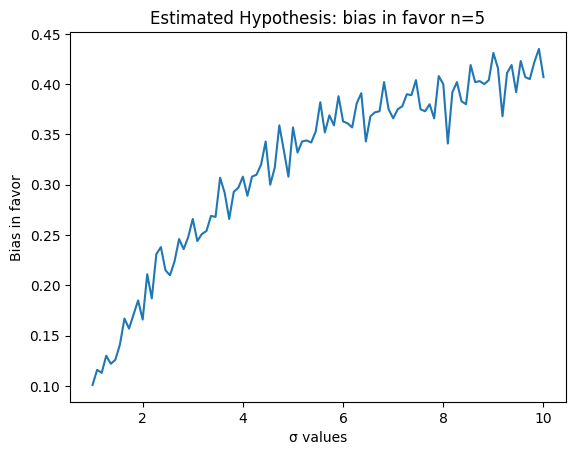

In [311]:
import numpy as np
n = 5; n_datasets = 1000; hypothesis = 1; σ = 1
σ = np.linspace(1, 10, 100)

loops = 100
biases = [simulation_hypothesis_bias_against_normal_1p(n_sample=n, hypothesis=hypothesis, n_datasets=n_datasets, sigma = σ[i], cumulative=False) for i in range(loops)]

plt.plot(σ, biases)
plt.title(f"Estimated Hypothesis: bias against n=5")
plt.xlabel('σ values')
plt.ylabel('Bias Against')
plt.show()

## Hypothesis bias in favor

In [299]:
def simulation_hypothesis_bias_in_favor_normal_1p(n_sample, hypothesis, delta, n_datasets=1000, n_marginal=1000, sigma=1, prior_mu=0, prior_σ=1, cumulative=False):
    """
    Estimates the bias in favor of a normal hypothesis by comparing the likelihoods of two normal distributions 
    (one shifted by +delta and the other by -delta) relative to the marginal likelihood under the prior. The 
    function returns the proportion of iterations where the likelihood exceeds the marginal likelihood for both 
    shifted distributions and selects the maximum bias.

    Parameters:
    ----------
    n_sample : int
        Number of samples drawn from the normal distributions (shifted by +delta and -delta).
    hypothesis : float
        The mean of the normal distribution representing the hypothesis being tested.
    delta : float
        The amount by which the mean of the normal distributions is shifted (positive and negative).
    n_datasets : int, optional
        Number of datasets for sampling (default is 1000).
    n_marginal : int, optional (default=1000)
        The number of samples used to approximate the marginal likelihood.
    sigma : float, optional
        The standard deviation of the normal distributions (default is 1).
    prior_mu : float, optional
        The mean of the prior distribution for the parameter (default is 0).
    prior_σ : float, optional
        The standard deviation of the prior distribution (default is 1).
    cumulative : bool, optional
        If True, returns the cumulative bias in favor after 300 iterations (burn-in period). If False, returns the 
        final bias in favor value (default is False).
    
    Returns:
    -------
    np.ndarray or float
        If `cumulative` is True, returns an array representing the cumulative bias in favor after the burn-in period.
        If `cumulative` is False, returns a float representing the final bias in favor value after all iterations.
    
    Internal Logic:
    ---------------
    1. Two normal distributions are defined for each hypothesis shift:
       - One with mean `hypothesis + delta`.
       - The other with mean `hypothesis - delta`.
    
    2. Samples are drawn from both distributions for each iteration.
    
    3. The log-likelihoods of the samples are computed assuming the hypothesis distribution (mean = hypothesis).
    
    4. The marginal log-likelihood is estimated by averaging over samples drawn from the prior distribution centered 
       at `prior_mu` and with standard deviation `prior_σ`.
    
    5. Bias in favor is determined by checking whether the log-likelihoods of the shifted distributions are greater 
       than or equal to the marginal log-likelihood.
    
    6. Cumulative bias in favor is computed as the running mean of bias indicators (i.e., whether the log-likelihood 
       exceeded the marginal log-likelihood).
    
    7. The function computes the cumulative bias for both the `+delta` and `-delta` shifts and returns the one 
       with the higher cumulative bias.
    """
    
    def normal_logp_np(x, mu, sigma):
        """Compute the log-likelihood for the normal distribution."""
        return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

    # Define the prior distribution for sampling the marginal likelihood
    prior_dist = stats.norm(loc=prior_mu, scale=prior_σ)
    μ = prior_dist.rvs(size=(n_marginal))  # Samples from the prior

    # Initialize to store results for +delta and -delta cases
    bias_in_favor_cumsums = []

    # Loop over +delta and -delta shifts
    for shift in [+delta, -delta]:
        # Define the normal distribution for the hypothesis shift
        normal_dist_shift = stats.norm(loc=hypothesis + shift, scale=sigma)

        # Sample from the shifted distribution
        x_shift = normal_dist_shift.rvs(size=(n_sample, n_datasets))

        # Compute the log-likelihood for the hypothesis with the shifted samples
        log_likelihood_shift = normal_logp_np(x_shift, hypothesis, sigma).sum(axis=0)

        # Estimate the marginal log-likelihood using logsumexp for numerical stability
        marginal_log_likelihood = logsumexp(np.sum(normal_logp_np(x_shift[:, :, np.newaxis], μ, sigma), axis=0), axis=1) - np.log(n_marginal)

        # Determine bias in favor: compare log-likelihoods to marginal log-likelihoods
        bias_in_favor = (log_likelihood_shift - marginal_log_likelihood) > 0

        # Calculate cumulative bias in favor (running mean)
        bias_in_favor_cumsum = bias_in_favor.cumsum() / np.arange(1, len(bias_in_favor) + 1)
        bias_in_favor_cumsums.append(bias_in_favor_cumsum)

    # Compare the cumulative bias for +delta and -delta, and choose the one with higher cumulative bias
    final_bias_cumsum = max(bias_in_favor_cumsums, key=lambda x: x[-1])

    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return final_bias_cumsum[300:]  # Return cumulative bias after burn-in
    else:
        return final_bias_cumsum[-1]  # Return final bias in favor value



### Example

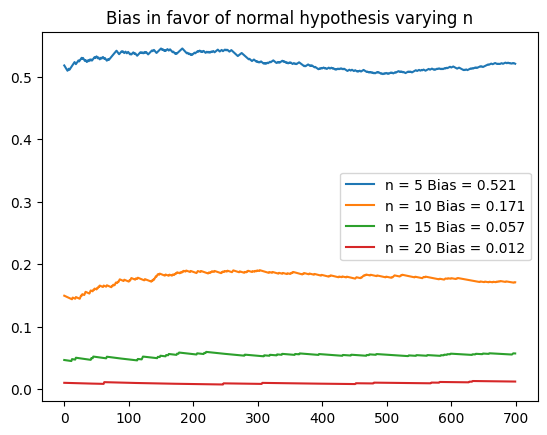

In [309]:
n = [5,10,15,20] 
sigma = 1
for i in range(4):
    bias = simulation_hypothesis_bias_in_favor_normal_1p(n_sample=n[i] , hypothesis=1, delta = 1, n_datasets=1000, sigma = sigma, cumulative=True)
    plt.plot(bias, label = f"n = {n[i]} Bias = {bias[-1]}")
plt.legend()
plt.title("Bias in favor of normal hypothesis varying n")
plt.show()


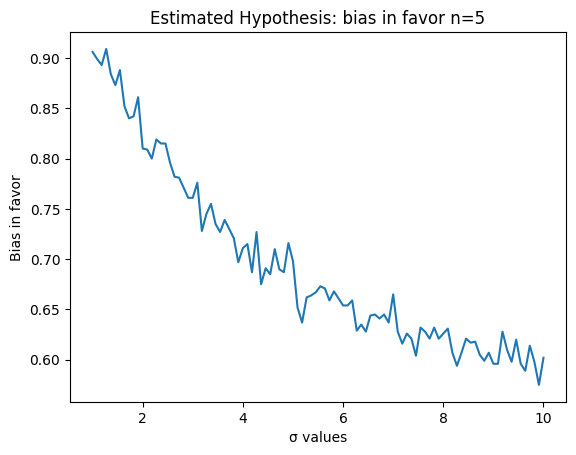

In [254]:
import numpy as np
n = 5; n_datasets = 1000; hypothesis = 1; σ = 1
σ = np.linspace(1, 10, 100)
deltas = 0.05

loops = 100
biases = [simulation_hypothesis_bias_in_favor_normal_1p(n_sample=n, hypothesis=hypothesis, delta = deltas, n_datasets=n_datasets, sigma = σ[i], cumulative=False) for i in range(loops)]

plt.plot(σ, biases)
plt.title(f"Estimated Hypothesis: bias in favor n=5")
plt.xlabel('σ values')
plt.ylabel('Bias in favor')
plt.show()


# Estimation

## Estimation Bias Against

In [344]:
def simulation_estimation_bias_against_normal_1p(n_sample, n_datasets=1000, n_marginal=1000, sigma=1, prior_mu=0, prior_sigma=1, cumulative=False):
    """
    Estimates the bias against a normal parameter estimate by comparing the log-likelihood of samples with the 
    marginal log-likelihood under a prior distribution. The function calculates the proportion of iterations where 
    the log-likelihood is less than or equal to the marginal log-likelihood, indicating estimation bias against the 
    parameter.

    Parameters:
    ----------
    n_sample : int
        The number of samples drawn from the likelihood distribution for each dataset.
    
    n_datasets : int, optional (default=1000)
        The number of iterations or datasets to generate for bias estimation.
    
    n_marginal : int, optional (default=1000)
        The number of samples drawn from the prior distribution to estimate the marginal likelihood.
    
    sigma : float, optional (default=1)
        The standard deviation of the normal likelihood distribution.
    
    prior_mu : float, optional (default=0)
        The mean of the prior distribution for the parameter.
    
    prior_σ : float, optional (default=1)
        The standard deviation of the prior distribution for the parameter.
    
    cumulative : bool, optional (default=False)
        If True, returns the cumulative bias against after 300 iterations (burn-in period). If False, returns the 
        final bias against value after all iterations.

    Returns:
    -------
    np.ndarray or float
        If `cumulative=True`, returns a 1D array representing the cumulative bias against after the burn-in period.
        If `cumulative=False`, returns a float representing the final bias against value after all iterations.
    
    Internal Logic:
    ---------------
    1. **Prior Distribution Sampling**: 
       - Samples `μ` are drawn from the prior distribution representing the parameter of interest.

    2. **Likelihood Distribution Definition**: 
       - For each sampled `μ`, a normal likelihood distribution is defined using the given `sigma`.

    3. **Sample Generation**: 
       - Samples `x` are drawn from this likelihood distribution for each dataset iteration.

    4. **Log-Likelihood Calculation**: 
       - The log-likelihood of the samples is computed using the sampled `μ` values.

    5. **Marginal Log-Likelihood Estimation**: 
       - The marginal log-likelihood is estimated by averaging over the likelihoods of all sampled `μ` values.

    6. **Bias Against Calculation**: 
       - Bias against is determined by comparing the log-likelihood of the samples to the marginal log-likelihood. 
         Bias against is recorded when the log-likelihood is less than or equal to the marginal log-likelihood.

    7. **Cumulative Bias Calculation**: 
       - The cumulative bias against is calculated as the running mean of the bias indicators, i.e., whether the 
         log-likelihood was less than or equal to the marginal log-likelihood over time.

    Example:
    --------
    # Example usage to estimate bias against a normal parameter estimate:
    n_sample = 50
    n_datasets = 1000
    sigma = 1
    prior_mu = 0
    prior_sigma = 1
    cumulative = True

    result = simulation_estimation_bias_against_normal_1p(n_sample, n_datasets, sigma=sigma, prior_mu=prior_mu, 
                                                          prior_sigma=prior_sigma, cumulative=cumulative)
    """
    
    # Define a function to compute the log-likelihood of a normal distribution
    def normal_logp_np(x, mu, sigma):
        return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

    # Pre-sample all theta_0 values
    theta_0_samples = stats.norm(prior_mu, prior_sigma).rvs(size=n_datasets)
    
    # Pre-sample theta_j_samples for marginal likelihood estimation
    theta_j_samples = stats.norm(prior_mu, prior_sigma).rvs(size=n_marginal)

    # Define the likelihood distribution, with the mean based on sampled μ values
    likeli_dist = stats.norm(loc=theta_0_samples, scale=sigma)
    
    # Sample x from the likelihood distribution, using μ as the mean for each iteration
    x = likeli_dist.rvs(size=(n_sample, n_datasets))

    # Compute the log-likelihood for the parameter estimate (μ)
    log_likelihood = normal_logp_np(x, theta_0_samples, sigma).sum(axis=0)

    # Compute the marginal log-likelihood by averaging over the sampled μ values
    
    marginal_log_likelihood = logsumexp(np.sum(normal_logp_np(x[:, :, np.newaxis], theta_j_samples, sigma), axis=0), axis=1) - np.log(n_marginal) #np.log(np.mean(np.exp(np.sum(normal_logp_np(x[:, :, np.newaxis], theta_j_samples, sigma), axis=0)), axis=1))

    # Determine bias against the estimate by comparing the log-likelihood to the marginal log-likelihood
    bias_against = (log_likelihood - marginal_log_likelihood) <= 0

    # Compute the cumulative bias against (running mean of bias indicators)
    bias_against_cumsum = bias_against.cumsum() / np.arange(1, len(bias_against) + 1)

    # Return cumulative bias after burn-in (if cumulative=True), or the final bias value
    if cumulative:
        return bias_against_cumsum[300:]  # Return cumulative bias after burn-in period
    else:
        return bias_against_cumsum[-1]  # Return final bias in favor value

In [348]:
# Example parameters
mu_0 = 0.0         # Prior mean
sigma_0 = 1.0        # Prior standard deviation
sigma = 1.0        # Known standard deviation
n = 50             # Sample size
n_datasets = 1000      # Number of iterations

np.mean([simulation_estimation_bias_against_normal_1p(n_sample=n, n_datasets=n_datasets, sigma = sigma,prior_sigma= sigma_0, cumulative=False) for _ in range(100)])

0.031650000000000005

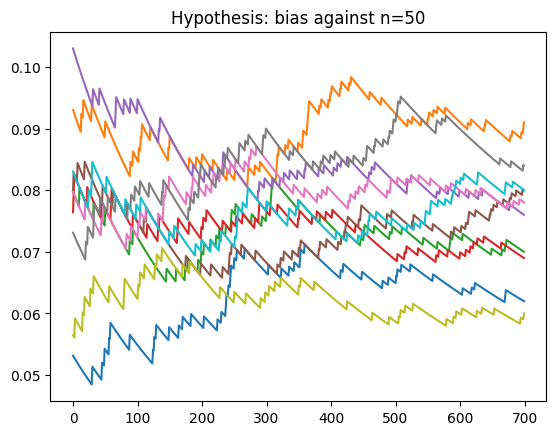

In [342]:
n = 10; n_datasets = 1000; sigma = 1

loops = 10
bias_against = [simulation_estimation_bias_against_normal_1p(n_sample=n, n_datasets=n_datasets, sigma = sigma, cumulative=True) for i in range(loops)]

for i in range(loops):
    plt.plot(bias_against[i])
    plt.title(f"Hypothesis: bias against n=50")
plt.show()


## Estimation Bias in Favor

In [356]:
from scipy.stats import norm
def simulation_estimation_bias_in_favor(
    n_sample,      # Sample size of each dataset x
    delta,         # The distance delta
    n_iter=50,     # Adjusted number of iterations over theta_0
    sigma=1,       # Known standard deviation of data
    prior_mu=0,    # Mean of the prior
    prior_sigma=1, # Standard deviation of the prior
    n_marginal=500,  # Adjusted number of samples to estimate p(x)
    n_datasets=50,    # Adjusted number of datasets per theta
    cumulative=False  # Return cumulative bias if True, otherwise return the final bias value
):
    """
    Estimates bias in favor of a normal parameter estimate by comparing the likelihood of a sample
    with its marginal likelihood under a prior. The function returns the proportion of iterations 
    where the log-likelihood exceeds the marginal log-likelihood for two hypotheses 
    (theta_0 + delta and theta_0 - delta). The maximum bias between the two hypotheses is retained.

    Parameters:
    ----------
    n_sample : int
        The number of samples drawn from the likelihood distribution for each dataset.
    
    delta : float
        The amount by which the parameter (theta) is shifted from theta_0. Two comparisons are 
        made: one with theta_0 + delta and one with theta_0 - delta.
    
    n_iter : int, optional (default=50)
        The number of iterations over different values of theta_0.
    
    sigma : float, optional (default=1)
        The known standard deviation of the normal likelihood distribution.
    
    prior_mu : float, optional (default=0)
        The mean of the normal prior distribution over theta.
    
    prior_sigma : float, optional (default=1)
        The standard deviation of the normal prior distribution over theta.
    
    n_marginal : int, optional (default=500)
        The number of samples used to estimate the marginal likelihood (p(x)).
    
    n_datasets : int, optional (default=50)
        The number of datasets generated for each iteration over theta.
    
    cumulative : bool, optional (default=False)
        If True, returns the cumulative bias in favor over all iterations. If False, returns the 
        final bias estimate after all iterations.

    Returns:
    -------
    np.ndarray or float
        If `cumulative=True`, returns an array representing the cumulative bias in favor after 
        all iterations. If `cumulative=False`, returns a float representing the final bias in favor 
        value after all iterations.
    
    Algorithm Overview:
    -------------------
    1. Pre-sample a set of `theta_0` values from the prior distribution (normal with mean `prior_mu`
       and standard deviation `prior_sigma`).
    
    2. For each `theta_0`:
        - Consider two hypotheses: `theta_0 + delta` and `theta_0 - delta`.
        - For each hypothesis, generate datasets by sampling from the normal likelihood distribution.
    
    3. Compute the log-likelihood of the datasets given the `theta_0`.
    
    4. Estimate the marginal log-likelihood (`log p(x)`) via Monte Carlo integration by sampling
       from the prior distribution.
    
    5. Compute the log relative belief ratio (`log_rb`) by comparing the log-likelihood of the
       dataset given `theta_0` to the marginal log-likelihood.
    
    6. For each dataset, determine bias in favor if the log relative belief ratio (`log_rb`) is positive.
    
    7. Repeat steps 2-6 for both `theta_0 + delta` and `theta_0 - delta` and store the maximum bias
       from the two hypotheses.
    
    8. Average the maximum biases across all iterations to get the final bias estimate in favor.

    9. If `cumulative=True`, return the cumulative sum of the bias values, otherwise return the final 
       averaged bias value.

    Example:
    --------
    # Estimate bias in favor for a normal parameter with the following parameters:
    n_sample = 100
    delta = 0.1
    n_iter = 50
    sigma = 1
    prior_mu = 0
    prior_sigma = 1
    cumulative = False

    result = simulation_estimation_bias_in_favor(
        n_sample=n_sample, delta=delta, n_iter=n_iter, sigma=sigma, 
        prior_mu=prior_mu, prior_sigma=prior_sigma, cumulative=cumulative
    )
    """
    
    # Pre-sample all theta_0 values
    theta_0_samples = np.random.normal(prior_mu, prior_sigma, size=n_iter)
    
    # Pre-sample theta_j_samples for marginal likelihood estimation
    theta_j_samples = np.random.normal(prior_mu, prior_sigma, size=n_marginal)
    
    # Initialize an array to store the maximum biases from each iteration
    max_biases = np.zeros(n_iter)
    
    for i, theta_0 in enumerate(theta_0_samples):
        # Array to store biases for theta = theta_0 + delta and theta_0 - delta
        biases = []
        
        for delta_sign in [+delta, -delta]:
            # Step 2: Set theta = theta_0 + delta or theta_0 - delta
            theta = theta_0 + delta_sign
            
            # Step 3: Generate multiple datasets x from p(x | theta)
            # x shape: (n_sample, n_datasets)
            x = np.random.normal(theta, sigma, size=(n_sample, n_datasets))
            
            # Step 4: Compute log p(x | theta_0) for each dataset
            # log_p_x_given_theta0 shape: (n_datasets,)
            log_p_x_given_theta0 = np.sum(norm.logpdf(x, loc=theta_0, scale=sigma), axis=0)
            
            # Step 5: Estimate log p(x) via Monte Carlo integration for all datasets simultaneously
            # Expand dimensions for broadcasting
            x_expanded = x[:, :, np.newaxis]  # Shape: (n_sample, n_datasets, 1)
            
            # Compute log p(x | theta_j) using broadcasting
            # log_p_x_given_thetaj shape: (n_datasets, n_marginal)
            log_p_x_given_thetaj = np.sum(
                norm.logpdf(x_expanded, loc=theta_j_samples, scale=sigma),
                axis=0
            )
            
            # Compute log p(x) for each dataset
            # log_p_x shape: (n_datasets,)
            log_p_x = logsumexp(log_p_x_given_thetaj, axis=1) - np.log(n_marginal)
            
            # Step 6: Compute the log relative belief ratio for each dataset
            log_rb = log_p_x_given_theta0 - log_p_x
            
            # Step 7: Determine bias for each dataset
            biases_datasets = np.array([log_rb > 0])
            
            # Step 8: Compute the bias for this theta as the mean over datasets
            bias = biases_datasets.mean()
            
            # Store the bias for this delta sign
            biases.append(bias)
        
        # Step 9: Store the maximum of the two biases
        max_biases[i] = max(biases)
    
    # Step 10: Average all the max biases to get the final bias in favor
    bias_in_favor_estimate = max_biases.mean()
    
    # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return max_biases.cumsum() / np.arange(1, len(max_biases) + 1)  # Return cumulative bias after burn-in
    else:
        return bias_in_favor_estimate  # Return final bias in favor value


Bias in Favor (Estimation): 0.6891000000000002


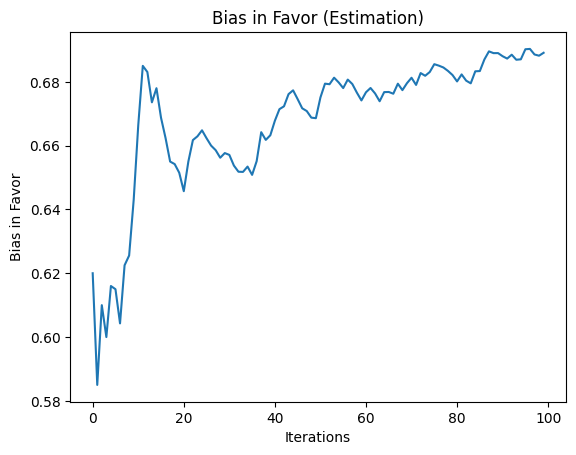

In [359]:

# Parameters for the test
n_sample = 10
delta = 0.5
n_iter = 100        # Adjusted number of theta_0 samples
sigma = 1
prior_mu = 0
prior_sigma = 1
n_marginal = 500   # Adjusted number of samples to estimate p(x)
n_datasets = 100    # Adjusted number of datasets per theta

# Run the function with the adjusted parameters
bias_in_favor = simulation_estimation_bias_in_favor(
    n_sample=n_sample,
    delta=delta,
    n_iter=n_iter,
    sigma=sigma,
    prior_mu=prior_mu,
    prior_sigma=prior_sigma,
    n_marginal=n_marginal,
    n_datasets=n_datasets,
    cumulative=True
)
plt.plot(bias_in_favor)
plt.title("Bias in Favor (Estimation)")
plt.xlabel("Iterations")
plt.ylabel("Bias in Favor")
print(f"Bias in Favor (Estimation): {bias_in_favor[-1]}")
